---
```
> Author: Huynh Van Thong
> hvthong.95@gmail.com
> Chonnam National University
```
---
### Computer Vision - Final Project
#### Object Classification with Bag-of-Visual-Word, Logistic Regression

## Import Library

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report
import scipy.cluster.vq as vq
from glob import glob
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import seaborn as sns

## Utility: get list of sub-folder, list of image in a folder --- SIFT extractor for all images in a folder

In [2]:
def get_categories(dataset_path):
    """
    Get list of sub-folder in dataset_path
    Return: list of paths to them
    """
    sub_folders = [files for files in glob(dataset_path + "/*") if os.path.isdir(files)]
    sub_folders.sort()
    cats = [os.path.basename(sub_folder) for sub_folder in sub_folders]
    return cats

def get_images(path):
    """
    Get list of image files in path
    Return: list of path to them
    """
    all_files = []
    for fname in glob(path + "/*"):
        if fname.endswith(".jpg"):
            all_files.extend([os.path.join(path, os.path.basename(fname))])
    return all_files

def sift_extract(files_input, labeled):
    """
    SIFT extract for all images in files_input
    Return: img_descriptors and labels in numpy array
    """
    img_descriptors = []
    n_img = 0
    
    for i, fname in enumerate(files_input):
        
        fimg = cv2.imread(fname)
        gray = cv2.cvtColor(fimg, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        
        # keypoint will be a list of keypoints and 
        # descriptor is numpy array of shape Number_of_Keypoints x 128
        keypoint, descriptor = sift.detectAndCompute(gray, None)
        
        if descriptor is None:
            #print("Cannot extract SIFT feature in image: ", fname)
            continue
        else:
            n_img += 1
            img_descriptors.append(descriptor)
    
    img_labels = [labeled] * n_img
    return img_descriptors, img_labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

  # print(cm)

    fig, ax = plt.subplots(1,figsize=(7, 7))
    ax = sns.heatmap(cm, ax=ax, cmap=cmap, annot=True)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)
  
    ax.set_title(title)
  
    fmt = '.2f' if normalize else 'd'

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def compute_confusion_matrix(y_test, y_pred):
    ''' Compute confusion matrix '''
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
  
    plot_confusion_matrix(cnf_matrix, classes=['motorbike', 'airplane'], normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

## Convert new image to vector when predict

In [3]:
def img2vec(img_path, model):
    """
    
    img_path: Path of image
    model: Model to cluster
    """
    im = cv2.imread(img_path)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sift_gen = cv2.xfeatures2d.SIFT_create()
    
    keypoint, descriptor = sift_gen.detectAndCompute(im_gray, None)
    if descriptor is None:
        #print("Cannot extract sift feature.")
        return None
    
    desc_cluster = model.predict(descriptor)
    histogram_bow = np.bincount(desc_cluster, minlength=model.n_clusters)
    
    # Reshape to 2D array, a row is a sample
    return np.reshape(histogram_bow, (1, -1))
    

# Generate sift feature for subset of folder in dataset_path

In [4]:
dataset_path = "D:/Dataset/Caltech_ObjectCategories/256_ObjectCategories"
dataset_path = "./Caltech256_subset"
cats = get_categories(dataset_path)
ncats = len(cats)

obj_names = []
all_sift_features = []
all_labels = []
n_object = 0
n_image = []
img_show_exampled = []

for cat, label in zip(cats, range(ncats)):
    
    cat_path = os.path.join(dataset_path, cat)
    cat_files = get_images(cat_path)
    
    if len(cat_files) > 750 and len(cat_files) < 820:
        # Extract sift features for images in current folder
        # if this folder has number of image in the greater than 500
        cat_features, cat_labels = sift_extract(cat_files, n_object)
        
        # Append list of sift feature, labels into corresponding list
        all_sift_features = all_sift_features + cat_features
        all_labels = all_labels + cat_labels
        n_image.append(len(cat_labels))
        obj_names.append(cat)
        n_object += 1
        
        img_show_exampled.append(cat_files[300])
        img_show_exampled.append(cat_files[500])

print("Summary of subset will be used\n")
print("  Object           Number of images")
print(" + " + obj_names[0][4:14] + "       " + str(n_image[0]))
print(" + " + obj_names[1][4:13] + "        " + str(n_image[1]))
#print(" + " + obj_names[2][4:11] + "          " + str(n_image[2]))
print("Number of object: ", n_object)
print("Number of images: ", len(all_labels))

all_sift_features = np.array(all_sift_features)
all_labels = np.array(all_labels)

Summary of subset will be used

  Object           Number of images
 + motorbikes       798
 + airplanes        800
Number of object:  2
Number of images:  1598


### Show some image example

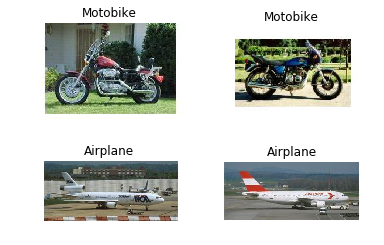

In [5]:
im = cv2.imread(img_show_exampled[0])
plt.subplot(221)
plt.title("Motobike")
plt.axis('off')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

im2 = cv2.imread(img_show_exampled[1])
plt.subplot(222)
plt.title("Motobike")
plt.axis('off')
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

im3 = cv2.imread(img_show_exampled[2])
plt.subplot(223)
plt.title("Airplane")
plt.axis('off')
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))

im4 = cv2.imread(img_show_exampled[3])
plt.subplot(224)
plt.title("Airplane")
plt.axis('off')
plt.imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))

## KMean for cluster bag-of-visual-word

In [6]:
def get_bow_features(X, model):
    """
    
    Get bow features for descriptors X of list of image
    Return: nxd array, n is number of image
    """
    ret = []
    for bf_words in X:
        clustered_words = model.predict(bf_words)
        hist_bow = np.bincount(clustered_words, minlength=model.n_clusters)
        ret.append(hist_bow)
    ret = np.array(ret)
    if ret.ndim == 1:
        ret = np.reshape(ret, (1, -1))
    return ret

def kmean_cluster(X, n_clusters):
    """
    
    Return: cluster model, nxd array, n is number of image in training set
    """
    model = MiniBatchKMeans(n_clusters=n_clusters, init_size=3*n_clusters)
    
    all_train_descriptors = []
    for img_descriptors in X:
        for descriptor in img_descriptors:
            all_train_descriptors.append(descriptor)
    all_train_descriptors = np.array(all_train_descriptors)
    
    model.fit(all_train_descriptors)
    
    imgs_histogram_bow = get_bow_features(X, model)
    
    return imgs_histogram_bow, model
        

## Split dataset into training set and testing set

In [7]:
# Test set: 25 percent
# Train set: 75 percent

X_train, X_test, y_train, y_test = train_test_split(all_sift_features, all_labels, test_size=0.25, random_state=42)
X_train_bow, kmean_model = kmean_cluster(X_train, n_clusters=1000)
X_test_bow = get_bow_features(X_test, kmean_model)

print("Training set shape: ", X_train_bow.shape, y_train.shape)
print("Testing set shape: ", X_test_bow.shape, y_test.shape)

Training set shape:  (1198, 1000) (1198,)
Testing set shape:  (400, 1000) (400,)


## LogisticRegression Training

Normalized confusion matrix


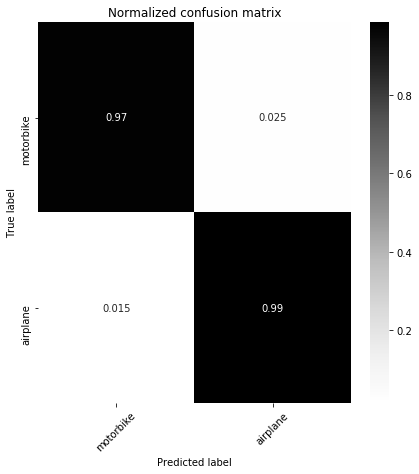

['./model/kmean_model.pkl']

In [8]:
clf = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), cv=5, random_state=42, n_jobs=5, max_iter=5000)

clf.fit(X_train_bow, y_train)

y_pred = clf.predict(X_test_bow)

compute_confusion_matrix(y_test, y_pred)

# Save model
joblib.dump(clf, "./model/logistic.pkl")
joblib.dump(kmean_model, "./model/kmean_model.pkl")

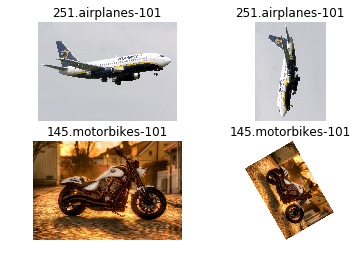

In [9]:
# Load model
clf = joblib.load("./model/best_logistic.pkl")
kmean_model = joblib.load("./model/best_kmean_model.pkl")

fnamet = ["./Test/airplane_0.jpg",
         "./Test/airplane_0_1.jpg",
         "./Test/airplane_0.jpg",
         "./Test/motorbike_2.jpg",
         "./Test/motorbike_2_1.jpg"]

img = cv2.imread(fnamet[0])
img_bow = img2vec(fnamet[0], kmean_model)
fpred = int(clf.predict(img_bow))
plt.subplot(221)
plt.title(obj_names[fpred])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = cv2.imread(fnamet[1])
img_bow = img2vec(fnamet[1], kmean_model)
fpred = int(clf.predict(img_bow))
plt.subplot(222)
plt.title(obj_names[fpred])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = cv2.imread(fnamet[3])
img_bow = img2vec(fnamet[3], kmean_model)
fpred = int(clf.predict(img_bow))
plt.subplot(223)
plt.title(obj_names[fpred])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = cv2.imread(fnamet[4])
img_bow = img2vec(fnamet[4], kmean_model)
fpred = int(clf.predict(img_bow))
plt.subplot(224)
plt.title(obj_names[fpred])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))